In [1]:
#Replaces io.utils
#Check AA lab compatibiltiy
'''
Created on Nov, 2016

@author: hugo

'''
from __future__ import absolute_import

import json
#import cPickle as pickle
import pickle as pickle
import marshal as m


def dump_marshal(data, path_to_file):
    try:
        with open(path_to_file, 'w') as f:
            m.dump(data, f)
    except Exception as e:
        raise e

def load_marshal(path_to_file):
    try:
        with open(path_to_file, 'r') as f:
            data = m.load(f)
    except Exception as e:
        raise e

    return data

def dump_pickle(data, path_to_file):
    try:
        with open(path_to_file, 'w') as f:
            pickle.dump(data, f)
    except Exception as e:
        raise e

def load_pickle(path_to_file):
    try:
        with open(path_to_file, 'r') as f:
            data = pickle.load(f)
    except Exception as e:
        raise e

    return data

def dump_json(data, file):
    try:
        with open(file, 'w') as datafile:
            json.dump(data, datafile)
    except Exception as e:
        raise e

def load_json(file):
    try:
        with open(file, 'r') as datafile:
            data = json.load(datafile)
    except Exception as e:
        raise e

    return data

def write_file(data, file):
    try:
        with open(file, 'w') as datafile:
            for line in data:
                datafile.write(' '.join(line) + '\n')
    except Exception as e:
        raise e

def load_file(file, float_=False):
    data = []
    try:
        with open(file, 'r') as datafile:
            for line in datafile:
                content = line.strip('\n').split()
                if float_:
                    content = [float(x) for x in content]
                data.append(content)
    except Exception as e:
        raise e

    return data


In [2]:
tf.__version__

NameError: name 'tf' is not defined

In [10]:

### Replace from keras_utils import Dense_tied, KCompetitive, contractive_loss, CustomModelCheckpoint

'''
Created on Nov, 2016

@author: hugo

'''
from __future__ import absolute_import
import os
import numpy as np
from keras.layers import Dense
from keras.callbacks import Callback
import keras.backend as K
from keras.engine import Layer
import tensorflow as tf
from keras import initializers
import warnings

#from ..testing.visualize import heatmap
#rom .op_utils import unitmatrix replace cell 

def contractive_loss(model, lam=1e-4):
    def loss(y_true, y_pred):
        ent_loss = K.mean(K.binary_crossentropy(y_pred, y_true), axis=-1)

        W = K.variable(value=model.encoder.get_weights()[0])  # N x N_hidden
        W = K.transpose(W)  # N_hidden x N
        h = model.encoder.output
        dh = h * (1 - h)  # N_batch x N_hidden

        # N_batch x N_hidden * N_hidden x 1 = N_batch x 1
        contractive = lam * K.sum(dh**2 * K.sum(W**2, axis=1), axis=1)

        return ent_loss + contractive
    return loss


def weighted_binary_crossentropy(feature_weights):
    def loss(y_true, y_pred):
        # try:
        #     x = K.binary_crossentropy(y_pred, y_true)
        #     # y = tf.Variable(feature_weights.astype('float32'))
        #     # z = K.dot(x, y)
        #     y_true = tf.pow(y_true + 1e-5, .75)
        #     y2 = tf.div(y_true, tf.reshape(K.sum(y_true, 1), [-1, 1]))
        #     z = K.sum(tf.mul(x, y2), 1)
        # except Exception as e:
        #     print e
        #     import pdb;pdb.set_trace()
        # return z
        return K.dot(K.binary_crossentropy(y_pred, y_true), K.variable(feature_weights.astype('float32')))
    return loss


class KCompetitive(Layer):
    '''Applies K-Competitive layer.

    # Arguments
    '''
    def __init__(self, topk, ctype, **kwargs):
        self.topk = topk
        self.ctype = ctype
        self.uses_learning_phase = True
        self.supports_masking = True
        super(KCompetitive, self).__init__(**kwargs)

    def call(self, x):
        if self.ctype == 'ksparse':
            return K.in_train_phase(self.kSparse(x, self.topk), x)
        elif self.ctype == 'kcomp':
            return K.in_train_phase(self.k_comp_tanh(x, self.topk), x)
        else:
            warnings.warn("Unknown ctype, using no competition.")
            return x

    def get_config(self):
        config = {'topk': self.topk, 'ctype': self.ctype}
        base_config = super(KCompetitive, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    # def k_comp_sigm(self, x, topk):
    #     print 'run k_comp_sigm'
    #     dim = int(x.get_shape()[1])
    #     if topk > dim:
    #         warnings.warn('topk should not be larger than dim: %s, found: %s, using %s' % (dim, topk, dim))
    #         topk = dim

    #     values, indices = tf.nn.top_k(x, topk) # indices will be [[0, 1], [2, 1]], values will be [[6., 2.], [5., 4.]]

    #     # We need to create full indices like [[0, 0], [0, 1], [1, 2], [1, 1]]
    #     my_range = tf.expand_dims(tf.range(0, K.shape(indices)[0]), 1)  # will be [[0], [1]]
    #     my_range_repeated = tf.tile(my_range, [1, topk])  # will be [[0, 0], [1, 1]]

    #     full_indices = tf.stack([my_range_repeated, indices], axis=2) # change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
    #     full_indices = tf.reshape(full_indices, [-1, 2])

    #     to_reset = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(values, [-1]), default_value=0., validate_indices=False)

    #     batch_size = tf.to_float(tf.shape(x)[0])
    #     tmp = 1 * batch_size * tf.reduce_sum(x - to_reset, 1, keep_dims=True) / topk

    #     res = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(tf.add(values, tmp), [-1]), default_value=0., validate_indices=False)

    #     return res

    def k_comp_tanh(self, x, topk, factor=6.26):
        print('run k_comp_tanh')
        dim = int(x.get_shape()[1])
        # batch_size = tf.to_float(tf.shape(x)[0])
        if topk > dim:
            warnings.warn('Warning: topk should not be larger than dim: %s, found: %s, using %s' % (dim, topk, dim))
            topk = dim

        P = (x + tf.abs(x)) / 2
        N = (x - tf.abs(x)) / 2
        
        
        values, indices = tf.nn.top_k(P, float(topk / 2)) # indices will be [[0, 1], [2, 1]], values will be [[6., 2.], [5., 4.]]
        # We need to create full indices like [[0, 0], [0, 1], [1, 2], [1, 1]]
        my_range = tf.expand_dims(tf.range(0, tf.shape(indices)[0]), 1)  # will be [[0], [1]]
        my_range_repeated = tf.tile(my_range, [1, int(topk / 2)])  # will be [[0, 0], [1, 1]]
        full_indices = tf.stack([my_range_repeated, indices], axis=2) # change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
        full_indices = tf.reshape(full_indices, [-1, 2])
        P_reset = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(values, [-1]), default_value=0., validate_indices=False)


        values2, indices2 = tf.nn.top_k(-N, int(topk - topk / 2) )
        my_range = tf.expand_dims(tf.range(0, tf.shape(indices2)[0]), 1)
        my_range_repeated = tf.tile(my_range, [1, int(topk - topk / 2) ])
        full_indices2 = tf.stack([my_range_repeated, indices2], axis=2)
        full_indices2 = tf.reshape(full_indices2, [-1, 2])
        N_reset = tf.sparse_to_dense(full_indices2, tf.shape(x), tf.reshape(values2, [-1]), default_value=0., validate_indices=False)


        # 1)
        # res = P_reset - N_reset
        # tmp = 1 * batch_size * tf.reduce_sum(x - res, 1, keep_dims=True) / topk

        # P_reset = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(tf.add(values, tf.abs(tmp)), [-1]), default_value=0., validate_indices=False)
        # N_reset = tf.sparse_to_dense(full_indices2, tf.shape(x), tf.reshape(tf.add(values2, tf.abs(tmp)), [-1]), default_value=0., validate_indices=False)

        # 2)
        # factor = 0.
        # factor = 2. / topk
        P_tmp = factor * tf.reduce_sum(P - P_reset, 1, keep_dims=True) # 6.26
        N_tmp = factor * tf.reduce_sum(-N - N_reset, 1, keep_dims=True)
        P_reset = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(tf.add(values, P_tmp), [-1]), default_value=0., validate_indices=False)
        N_reset = tf.sparse_to_dense(full_indices2, tf.shape(x), tf.reshape(tf.add(values2, N_tmp), [-1]), default_value=0., validate_indices=False)

        res = P_reset - N_reset

        return res

    # def k_comp_tanh_strict(self, x, topk):
    #     print 'run k_comp_tanh_strict'
    #     dim = int(x.get_shape()[1])
    #     # batch_size = tf.to_float(tf.shape(x)[0])
    #     if topk > dim:
    #         warnings.warn('Warning: topk should not be larger than dim: %s, found: %s, using %s' % (dim, topk, dim))
    #         topk = dim

    #     x_abs = tf.abs(x)
    #     P = (x + x_abs) / 2 # positive part of x
    #     N = (x - x_abs) / 2 # negative part of x

    #     values, indices = tf.nn.top_k(x_abs, topk) # indices will be [[0, 1], [2, 1]], values will be [[6., 2.], [5., 4.]]
    #     # We need to create full indices like [[0, 0], [0, 1], [1, 2], [1, 1]]
    #     my_range = tf.expand_dims(tf.range(0, tf.shape(indices)[0]), 1)  # will be [[0], [1]]
    #     my_range_repeated = tf.tile(my_range, [1, topk])  # will be [[0, 0], [1, 1]]
    #     full_indices = tf.stack([my_range_repeated, indices], axis=2) # change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
    #     full_indices = tf.reshape(full_indices, [-1, 2])
    #     x_topk_mask = tf.sparse_to_dense(full_indices, tf.shape(x), tf.ones([tf.shape(full_indices)[0], ], tf.float32), default_value=0., validate_indices=False)

    #     P_select = tf.multiply(P, x_topk_mask)
    #     N_select = tf.multiply(-N, x_topk_mask)

    #     zero = tf.constant(0., dtype=tf.float32)
    #     P_indices = tf.cast(tf.where(tf.not_equal(P_select, zero)), tf.int32)
    #     N_indices = tf.cast(tf.where(tf.not_equal(N_select, zero)), tf.int32)
    #     P_mask = tf.sparse_to_dense(P_indices, tf.shape(x), tf.ones([tf.shape(P_indices)[0], ], tf.float32), default_value=0., validate_indices=False)
    #     N_mask = tf.sparse_to_dense(N_indices, tf.shape(x), tf.ones([tf.shape(N_indices)[0], ], tf.float32), default_value=0., validate_indices=False)

    #     alpha = 10.
    #     P_complement = alpha * tf.reduce_sum(P - P_select, 1, keep_dims=True)# / tf.cast(tf.shape(P_indices)[0], tf.float32) # 6.26
    #     N_complement = alpha * tf.reduce_sum(-N - N_select, 1, keep_dims=True)# / tf.cast(tf.shape(N_indices)[0], tf.float32)

    #     P_reset = tf.multiply(tf.add(P_select, P_complement), P_mask)
    #     N_reset = tf.multiply(tf.add(N_select, N_complement), N_mask)
    #     res = P_reset - N_reset

    #     return res

    def kSparse(self, x, topk):
        print('run regular k-sparse')
        dim = int(x.get_shape()[1])
        if topk > dim:
            warnings.warn('Warning: topk should not be larger than dim: %s, found: %s, using %s' % (dim, topk, dim))
            topk = dim

        k = dim - topk
        values, indices = tf.nn.top_k(-x, k) # indices will be [[0, 1], [2, 1]], values will be [[6., 2.], [5., 4.]]

        # We need to create full indices like [[0, 0], [0, 1], [1, 2], [1, 1]]
        my_range = tf.expand_dims(tf.range(0, tf.shape(indices)[0]), 1)  # will be [[0], [1]]
        my_range_repeated = tf.tile(my_range, [1, k])  # will be [[0, 0], [1, 1]]

        full_indices = tf.stack([my_range_repeated, indices], axis=2) # change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
        full_indices = tf.reshape(full_indices, [-1, 2])

        to_reset = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(values, [-1]), default_value=0., validate_indices=False)

        res = tf.add(x, to_reset)

        return res


class Dense_tied(Dense):
    """
    A fully connected layer with tied weights.
    """
    def __init__(self, units,
                 activation=None, use_bias=True,
                 bias_initializer='zeros',
                 kernel_regularizer=None, bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None,
                 tied_to=None, **kwargs):
        self.tied_to = tied_to

        super(Dense_tied, self).__init__(units=units,
                 activation=activation, use_bias=use_bias,
                 bias_initializer=bias_initializer,
                 kernel_regularizer=kernel_regularizer, bias_regularizer=bias_regularizer,
                 activity_regularizer=activity_regularizer,
                 kernel_constraint=kernel_constraint, bias_constraint=bias_constraint,
                 **kwargs)

    def build(self, input_shape):
        super(Dense_tied, self).build(input_shape)  # be sure you call this somewhere!
        if self.kernel in self.trainable_weights:
            self.trainable_weights.remove(self.kernel)


    def call(self, x, mask=None):
        # Use tied weights
        self.kernel = K.transpose(self.tied_to.kernel)
        output = K.dot(x, self.kernel)
        if self.use_bias:
            output += self.bias
        return self.activation(output)

class CustomModelCheckpoint(Callback):
    """Save the model after every epoch.
    `filepath` can contain named formatting options,
    which will be filled the value of `epoch` and
    keys in `logs` (passed in `on_epoch_end`).
    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.
    # Arguments
        filepath: string, path to save the model file.
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        save_best_only: if `save_best_only=True`,
            the latest best model according to
            the quantity monitored will not be overwritten.
        mode: one of {auto, min, max}.
            If `save_best_only=True`, the decision
            to overwrite the current save file is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        save_weights_only: if True, then only the model's weights will be
            saved (`model.save_weights(filepath)`), else the full model
            is saved (`model.save(filepath)`).
        period: Interval (number of epochs) between checkpoints.
    """

    def __init__(self, custom_model, filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        super(CustomModelCheckpoint, self).__init__()
        self.custom_model = custom_model
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('CustomModelCheckpoint mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        model = self.custom_model
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch, **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('Epoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            model.save_weights(filepath, overwrite=True)
                        else:
                            model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('Epoch %05d: %s did not improve' %
                                  (epoch, self.monitor))
            else:
                if self.verbose > 0:
                    print('Epoch %05d: saving model to %s' % (epoch, filepath))
                if self.save_weights_only:
                    model.save_weights(filepath, overwrite=True)
                else:
                    model.save(filepath, overwrite=True)

class VisualWeights(Callback):
    def __init__(self, save_path, per_epoch=15):
        super(VisualWeights, self).__init__()
        self.per_epoch = per_epoch
        self.filename, self.ext = os.path.splitext(save_path)

    def on_epoch_end(self, epoch, logs=None):
        """Called at the end of an epoch.
        # Arguments
            epoch: integer, index of epoch.
            logs: dictionary of logs.
        """
        if epoch % self.per_epoch == 0:
            weights = self.model.get_weights()[0]
            # weights /= np.max(np.abs(weights))
            weights = unitmatrix(weights, axis=0) # normalize
            # weights[np.abs(weights) < 1e-2] = 0
            heatmap(weights.T, '%s_%s%s'%(self.filename, epoch, self.ext))


In [4]:

### Autoencoder.core.ae 
'''
Created on Nov, 2016

@author: hugo

'''
from __future__ import absolute_import
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adadelta
from keras.models import load_model as load_keras_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#from keras_utils import Dense_tied, KCompetitive, contractive_loss, CustomModelCheckpoint


class AutoEncoder(object):
    """AutoEncoder for topic modeling.

        Parameters
        ----------
        """

    def __init__(self, input_size, dim, comp_topk=int(5), ctype='kcomp', save_model='best_model'):
        self.input_size = input_size
        self.dim = dim
        self.comp_topk = comp_topk
        self.ctype = ctype
        self.save_model = save_model

        self.build()

    def build(self):
        # this is our input placeholder
        input_layer = Input(shape=(self.input_size,))

        # "encoded" is the encoded representation of the input
        if self.ctype == None:
            act = 'sigmoid'
        elif self.ctype == 'kcomp':
            act = 'tanh'
        elif self.ctype == 'ksparse':
            act = 'linear'
        else:
            raise Exception('unknown ctype: %s' % self.ctype)
        encoded_layer = Dense(self.dim, activation=act, kernel_initializer="glorot_normal", name="Encoded_Layer")
        encoded = encoded_layer(input_layer)

        if self.comp_topk:
            print('add k-competitive layer')
            encoded = KCompetitive(self.comp_topk, self.ctype)(encoded)

        # "decoded" is the lossy reconstruction of the input
        # add non-negativity contraint to ensure probabilistic interpretations
        decoded = Dense_tied(self.input_size, activation='sigmoid', tied_to=encoded_layer, name='Decoded_Layer')(encoded)

        # this model maps an input to its reconstruction
        self.autoencoder = Model(outputs=decoded, inputs=input_layer)

        # this model maps an input to its encoded representation
        self.encoder = Model(outputs=encoded, inputs=input_layer)

        # create a placeholder for an encoded input
        encoded_input = Input(shape=(self.dim,))
        # retrieve the last layer of the autoencoder model
        decoder_layer = self.autoencoder.layers[-1]
        # create the decoder model
        self.decoder = Model(outputs=decoder_layer(encoded_input), inputs=encoded_input)
#removing x_val from this call 
    def fit(self, train_X, val_X, nb_epoch=5, batch_size=508, contractive=None):
        optimizer = Adadelta(lr=2.)
        # optimizer = Adam()
        # optimizer = Adagrad()
        if contractive:
            print('Using contractive loss, lambda: %s' % contractive)
            self.autoencoder.compile(optimizer=optimizer, loss=contractive_loss(self, contractive))
        else:
            print('Using binary crossentropy')
            self.autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy') # kld, binary_crossentropy, mse

        self.autoencoder.fit(train_X[0], train_X[1],
                        epochs=5,
                        batch_size=batch_size,
                        #shuffle=True,
                        shuffle=True,
                        validation_data=(val_X[0], val_X[1])
                        #callbacks=[
                                    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01),
                                    #EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto'),
                                   #CustomModelCheckpoint(self.encoder, self.save_model, monitor='val_loss', save_best_only=True, mode='auto')
                      #  ]
                            )


        return self


In [5]:
254*2

508

In [6]:
########## Prepare data NLPCF
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

import seaborn as sns

import string
import gensim

os.chdir("/home/spenser/Downloads/")



CFPB_prod = pd.read_csv("complaints-2019-12-27_16_37.csv")

In [7]:
CFPB_Case_Study_Joined = CFPB_prod

In [8]:


import string 
#text already appears to be cleansed ... but, just making sure. limited pre-processing - these assumptions can be played around with when we build classifiers

CFPB_Case_Study_Joined["text_lower"] = CFPB_Case_Study_Joined["Consumer complaint narrative"].str.lower()

CFPB_Case_Study_Joined["text_lower"] = CFPB_Case_Study_Joined["text_lower"].str.replace(r'\nRevision: (\d+)\n', '') #remove digits

def remove_punctuations(text):

    for punctuation in string.punctuation:

        text = text.replace(punctuation, '')

    return text


CFPB_Case_Study_Joined["text_clean"] = CFPB_Case_Study_Joined['text_lower'].apply(remove_punctuations)  #remove punctuation


#Adding this due to finding below that pre-cleansed text is corrupt. (contains cases like can t) . Remove single stand-alone characters. ("a", "e", etc)

CFPB_Case_Study_Joined["text_clean"] = CFPB_Case_Study_Joined["text_clean"].str.replace(r'\b(?<=)[a-z](?=)\b', '') #remove single stand-alone characters.

 
cfpb_pd = CFPB_Case_Study_Joined

cfpb_pd["text_clean"] = cfpb_pd["text_clean"].str.replace(r'xx', '')
cfpb_pd["text_clean"] = cfpb_pd["text_clean"].str.replace(r'(.)\1{2,}', '')

cfpb_pd["word_count"] = cfpb_pd["text_clean"].str.count(' ') + 1

cfpb_pd = cfpb_pd[cfpb_pd["word_count"] >= 10]

In [9]:
def strip_extra_whitespace(doc):
        ws_stripped = " ".join(doc.split())
        return ws_stripped
    
cfpb_pd["text_clean_ws"] = CFPB_Case_Study_Joined['text_clean'].apply(strip_extra_whitespace)

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [13]:
import re
from nltk.corpus import stopwords
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def rm_s(doc):
    text = pattern.sub('', doc)
    return text

from multiprocessing import Pool

p = Pool(11)

cfpb_pd['text_clean_stopwords'] = p.map(rm_s, cfpb_pd['text_clean_ws'])

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [14]:
def tokenize(doc):
    tokens = doc.split(' ')
    return tokens

cfpb_pd["text_clean_tokenized"] = cfpb_pd["text_clean_stopwords"].apply(tokenize)

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
from nltk.stem.snowball import PorterStemmer
from multiprocessing import Pool
from nltk.stem.porter import *

porter = PorterStemmer()
        
def stemmed(text, cores=11): # tweak cores as needed
    
    stem_words = np.vectorize(porter.stem)

    stemed_text = stem_words(text)
    return stemed_text

p = Pool(11)
cfpb_pd["text_stemmed"] = p.map(stemmed, cfpb_pd["text_clean_tokenized"])

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [16]:
p.close()
p.terminate()

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

def detokenizer(doc):
    doc_detokenized = TreebankWordDetokenizer().detokenize(doc)
    return doc_detokenized
p = Pool(11)

cfpb_pd["text_stemmed_untokenized"] =  p.map(detokenizer,cfpb_pd["text_stemmed"])

p.close()
p.terminate()

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
import gc
gc.collect()

20

In [20]:
cfpb_pd = cfpb_pd[["Complaint ID",  "text_clean", "text_stemmed_untokenized", "Product"]]

In [21]:
import gc
p = []
q = []
gc.collect()

47

In [22]:
cfpb_pd.to_csv("cfpb_pd_stemmed_newdataset3.csv")

In [2]:
import pandas as pd

In [1]:
import pandas as pd
import os
import numpy as np
os.chdir("/home/spenser/Downloads/")

cfpb_pd = pd.read_csv("cfpb_pd_stemmed_newdataset3.csv")

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(min_df=10, norm='l1')
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cfpb_pd["text_stemmed_untokenized"], cfpb_pd['Product'], test_size=0.33, random_state=42)




In [3]:
cv.fit(X_train)

X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [6]:
X_train_cv

<315923x14906 sparse matrix of type '<class 'numpy.float64'>'
	with 26432812 stored elements in Compressed Sparse Row format>

In [4]:
X_train_cv.shape

(315923, 24396)

In [ ]:
X_train_cv= X_train_cv.tolil()
X_test_cv= X_test_cv.tolil()

In [5]:
features_names = cv.get_feature_names()

In [6]:
len(features_names)

24396

In [8]:

### Autoencoder.core.ae 
'''
Created on Nov, 2016

@author: hugo

'''
from __future__ import absolute_import
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adadelta
from keras.models import load_model as load_keras_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#from keras_utils import Dense_tied, KCompetitive, contractive_loss, CustomModelCheckpoint


class AutoEncoder(object):
    """AutoEncoder for topic modeling.

        Parameters
        ----------
        """

    def __init__(self, input_size, dim, comp_topk=int(30), ctype='kcomp', save_model='best_model'):
        self.input_size = input_size
        self.dim = dim
        self.comp_topk = comp_topk
        self.ctype = ctype
        self.save_model = save_model

        self.build()

    def build(self):
        # this is our input placeholder
        input_layer = Input(shape=(self.input_size,))

        # "encoded" is the encoded representation of the input
        if self.ctype == None:
            act = 'sigmoid'
        elif self.ctype == 'kcomp':
            act = 'tanh'
        elif self.ctype == 'ksparse':
            act = 'linear'
        else:
            raise Exception('unknown ctype: %s' % self.ctype)
        encoded_layer = Dense(self.dim, activation=act, kernel_initializer="glorot_normal", name="Encoded_Layer")
        encoded = encoded_layer(input_layer)

        if self.comp_topk:
            print('add k-competitive layer')
            encoded = KCompetitive(self.comp_topk, self.ctype)(encoded)

        # "decoded" is the lossy reconstruction of the input
        # add non-negativity contraint to ensure probabilistic interpretations
        decoded = Dense_tied(self.input_size, activation='sigmoid', tied_to=encoded_layer, name='Decoded_Layer')(encoded)

        # this model maps an input to its reconstruction
        self.autoencoder = Model(outputs=decoded, inputs=input_layer)

        # this model maps an input to its encoded representation
        self.encoder = Model(outputs=encoded, inputs=input_layer)

        # create a placeholder for an encoded input
        encoded_input = Input(shape=(self.dim,))
        # retrieve the last layer of the autoencoder model
        decoder_layer = self.autoencoder.layers[-1]
        # create the decoder model
        self.decoder = Model(outputs=decoder_layer(encoded_input), inputs=encoded_input)
#removing x_val from this call 
    def fit(self, train_X, val_X, nb_epoch=200, batch_size=64, contractive=None):
        optimizer = Adadelta(lr=2.)
        # optimizer = Adam()
        # optimizer = Adagrad()
        if contractive:
            print('Using contractive loss, lambda: %s' % contractive)
            self.autoencoder.compile(optimizer=optimizer, loss=contractive_loss(self, contractive))
        else:
            print('Using binary crossentropy')
            self.autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy') # kld, binary_crossentropy, mse

        self.autoencoder.fit(train_X[0], train_X[1],
                        epochs=250,
                        batch_size=batch_size,
                        #shuffle=True,
                        shuffle=True,
                        validation_data=(val_X[0], val_X[1])
                        #callbacks=[
                                    #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01),
                                    #EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto'),
                                   #CustomModelCheckpoint(self.encoder, self.save_model, monitor='val_loss', save_best_only=True, mode='auto')
                      #  ]
                            )


        return self


In [577]:


ae = AutoEncoder(len(features_names),dim =10, comp_topk=int(5), ctype='kcomp')
ae.autoencoder.summary()

add k-competitive layer
run k_comp_tanh
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 4110)              0         
_________________________________________________________________
Encoded_Layer (Dense)        (None, 10)                41110     
_________________________________________________________________
k_competitive_7 (KCompetitiv (None, 10)                0         
_________________________________________________________________
Decoded_Layer (Dense_tied)   (None, 4110)              4110      
Total params: 45,220
Trainable params: 45,220
Non-trainable params: 0
_________________________________________________________________


In [17]:
ae.autoencoder.weights

[<tf.Variable 'Encoded_Layer_1/kernel:0' shape=(4110, 10) dtype=float32_ref>,
 <tf.Variable 'Encoded_Layer_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Decoded_Layer/bias:0' shape=(4110,) dtype=float32_ref>]

In [18]:
ae.encoder.weights

[<tf.Variable 'Encoded_Layer_1/kernel:0' shape=(4110, 10) dtype=float32_ref>,
 <tf.Variable 'Encoded_Layer_1/bias:0' shape=(10,) dtype=float32_ref>]

In [19]:
ae.decoder.weights

[<tf.Variable 'Decoded_Layer/bias:0' shape=(4110,) dtype=float32_ref>]

In [17]:
'''
Created on Nov, 2016

@author: hugo

'''
from __future__ import absolute_import
import timeit
import argparse
from os import path



ae = AutoEncoder(len(features_names),dim =50, comp_topk=int(30), ctype='kcomp')

ae.fit([X_train_cv, X_train_cv], [X_test_cv, X_test_cv], nb_epoch=200,  batch_size=int(254), contractive=False)

 #       train_doc_codes = ae.encoder.predict(X_train)
  #      val_doc_codes = ae.encoder.predict(X_val)
  #      doc_keys = np.array(doc_keys)
  #      dump_json(dict(zip(doc_keys[train_idx].tolist(), train_doc_codes.tolist())), args.output + '.train')
  #      dump_json(dict(zip(doc_keys[val_idx].tolist(), val_doc_codes.tolist())), args.output + '.val')
  #      print('Saved doc codes file to %s and %s' % (args.output + '.train', args.output + '.val'))



add k-competitive layer
run k_comp_tanh
Using binary crossentropy
Train on 315923 samples, validate on 155605 samples
Epoch 1/250
315923/315923 [==============================] - 65s 205us/step - loss: 0.6729 - val_loss: 0.6531
Epoch 2/250
315923/315923 [==============================] - 67s 212us/step - loss: 0.6345 - val_loss: 0.6163
Epoch 3/250
315923/315923 [==============================] - 66s 210us/step - loss: 0.5991 - val_loss: 0.5824
Epoch 4/250
315923/315923 [==============================] - 66s 209us/step - loss: 0.5666 - val_loss: 0.5512
Epoch 5/250
315923/315923 [==============================] - 67s 213us/step - loss: 0.5366 - val_loss: 0.5224
Epoch 6/250
315923/315923 [==============================] - 68s 214us/step - loss: 0.5090 - val_loss: 0.4959
Epoch 7/250
315923/315923 [==============================] - 67s 212us/step - loss: 0.4835 - val_loss: 0.4713
Epoch 8/250
315923/315923 [==============================] - 67s 214us/step - loss: 0.4599 - val_loss: 0.4487
Ep

Epoch 74/250
315923/315923 [==============================] - 68s 214us/step - loss: 0.0881 - val_loss: 0.0875
Epoch 75/250
315923/315923 [==============================] - 68s 215us/step - loss: 0.0870 - val_loss: 0.0864
Epoch 76/250
315923/315923 [==============================] - 68s 214us/step - loss: 0.0858 - val_loss: 0.0853
Epoch 77/250
315923/315923 [==============================] - 57s 180us/step - loss: 0.0847 - val_loss: 0.0842
Epoch 78/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0836 - val_loss: 0.0831
Epoch 79/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0826 - val_loss: 0.0821
Epoch 80/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0815 - val_loss: 0.0810
Epoch 81/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0805 - val_loss: 0.0800
Epoch 82/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0796 - val_loss: 0.0791
E

315923/315923 [==============================] - 52s 165us/step - loss: 0.0292 - val_loss: 0.0291
Epoch 221/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0290 - val_loss: 0.0290
Epoch 222/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0289 - val_loss: 0.0288
Epoch 223/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0288 - val_loss: 0.0287
Epoch 224/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0286 - val_loss: 0.0286
Epoch 225/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0285 - val_loss: 0.0284
Epoch 226/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0284 - val_loss: 0.0283
Epoch 227/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0282 - val_loss: 0.0282
Epoch 228/250
315923/315923 [==============================] - 52s 165us/step - loss: 0.0281 - val_loss: 0.0281
Epoch 

In [548]:
import tensorflow
tensorflow.__version__

'1.13.1'

In [18]:
ae.autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 14906)             0         
_________________________________________________________________
Encoded_Layer (Dense)        (None, 50)                745350    
_________________________________________________________________
k_competitive_3 (KCompetitiv (None, 50)                0         
_________________________________________________________________
Decoded_Layer (Dense_tied)   (None, 14906)             14906     
Total params: 760,256
Trainable params: 760,256
Non-trainable params: 0
_________________________________________________________________


In [19]:
ae.encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 14906)             0         
_________________________________________________________________
Encoded_Layer (Dense)        (None, 50)                745350    
_________________________________________________________________
k_competitive_3 (KCompetitiv (None, 50)                0         
Total params: 745,350
Trainable params: 745,350
Non-trainable params: 0
_________________________________________________________________


In [20]:
encoded_docs = ae.encoder.predict(X_test_cv, batch_size=int(254))

In [22]:
y_test_c = pd.Categorical(y_test).codes

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

pca_encoded = pca.fit_transform(encoded_docs)


In [36]:
pca_encoded[:,1].max()

0.021986127

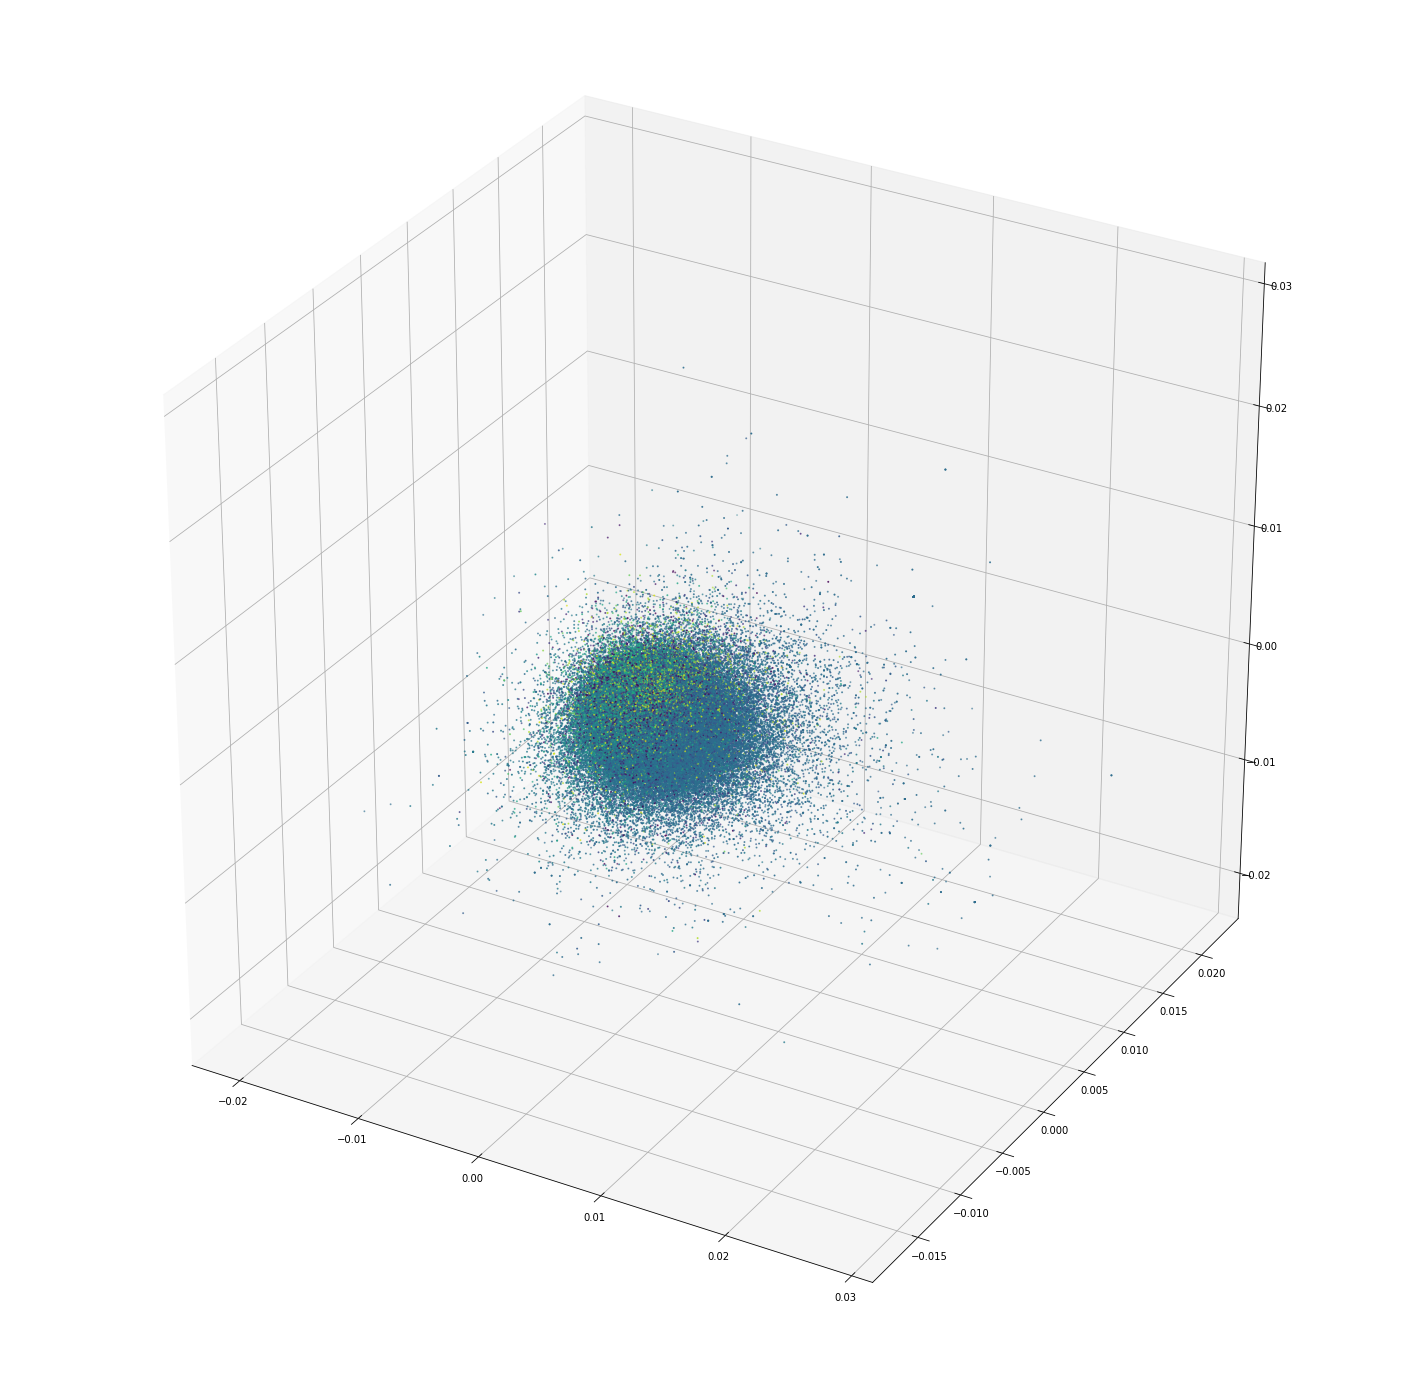

In [37]:
#from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')
ax.xlim=(-0.02, 0.015)
ax.ylim=(0.005, 0)
ax.zlim=(-0.02, 0)
# Grab some test data.
#X, Y, Z = axes3d.get_test_data(0.05)
X = pca_encoded[:,0]
Y = pca_encoded[:,1]
Z = pca_encoded[:,2]
# Plot a basic wireframe.
ax.scatter(X, Y, Z, s=1, c=y_test_c)

plt.show()

In [53]:
import umap
from sklearn.datasets import load_digits


embedding_umap_latent = umap.UMAP().fit_transform(encoded_docs)

/home/spenser/.conda/envs/gpu/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 4 separate connected components using meta-embedding (experimental)
  n_components


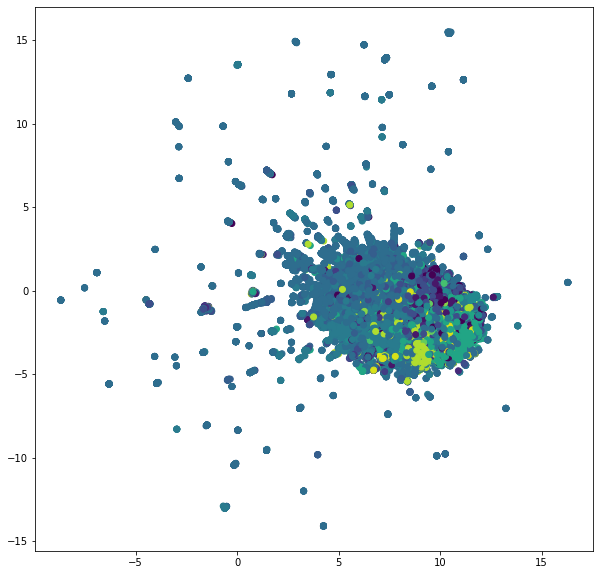

In [59]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# Grab some test data.
#X, Y, Z = axes3d.get_test_data(0.05)
X = embedding_umap_latent[:,0]
Y = embedding_umap_latent[:,1]
#Z = embedding_umap_latent[:,2]
# Plot a basic wireframe.
ax.scatter(X, Y, c=y_test_c)

plt.show()

In [60]:
'''
Created on Dec, 2016
@author: hugo
'''
from __future__ import absolute_import

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib as mpl
mpl.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate


class neural_net_visualizer(object):
    def __init__(self):
        pass



def heatmap(data, save_file='heatmap.png'):
    ax = plt.figure().gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MultipleLocator(5))
    plt.pcolor(data, cmap=plt.cm.jet)
    plt.savefig(save_file)
    # plt.show()


def get_indices(labels, c):
    idx = np.zeros(len(labels), dtype=bool)
    for i in range(len(labels)):
        tmp = [labels[i]] if not isinstance(labels[i], (list, set)) else labels[i]
        if c in tmp:
            idx[i] = True
    return idx

def plot_info_retrieval(precisions, save_file):
    # markers = ["|", "D", "8", "v", "^", ">", "h", "H", "s", "*", "p", "d", "<"]
    markers = ["D", "p", 's', "*", "d", "8", "^", "H", "v", ">", "<", "h", "|"]
    ticks = zip(*zip(*precisions)[1][0])[0]
    plt.xticks(range(len(ticks)), ticks)
    new_x = interpolate.interp1d(ticks, range(len(ticks)))(ticks)

    i = 0
    for model_name, val in precisions:
        fr, pr = zip(*val)
        plt.plot(new_x, pr, linestyle='-', alpha=0.7, marker=markers[i],
                        markersize=8, label=model_name)
        i += 1
        # plt.legend(model_name)
    plt.xlabel('Fraction of Retrieved Documents')
    plt.ylabel('Precision')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.savefig(save_file)
    plt.show()

def plot_info_retrieval_by_length(precisions, save_file):
    markers = ["o", "v", "8", "s", "p", "*", "h", "H", "^", "x", "D"]
    ticks = zip(*zip(*precisions)[1][0])[0]
    plt.xticks(range(len(ticks)), ticks)
    new_x = interpolate.interp1d(ticks, range(len(ticks)))(ticks)

    i = 0
    for model_name, val in precisions:
        fr, pr = zip(*val)
        plt.plot(new_x, pr, linestyle='-', alpha=0.6, marker=markers[i],
                        markersize=6, label=model_name)
        i += 1
        # plt.legend(model_name)
    plt.xlabel('Document Sorted by Length')
    plt.ylabel('Precision (%)')
    legend = plt.legend(loc='upper right', shadow=True)
    plt.savefig(save_file)
    plt.show()

def plot(x, y, x_label, y_label, save_file):
    ticks = x
    plt.xticks(range(len(ticks)), ticks, fontsize = 15)
    plt.yticks(fontsize = 15)
    new_x = interpolate.interp1d(ticks, range(len(ticks)))(ticks)

    plt.plot(new_x, y, linestyle='-', alpha=1.0, markersize=12, marker='p', color='b')
    plt.xlabel(x_label, fontsize=24)
    plt.ylabel(y_label, fontsize=20)
    plt.savefig(save_file)
    plt.show()


In [69]:
cv.vocabulary_.keys()

dict_keys(['am', 'to', 'file', 'thi', 'complaint', 'with', 'your', 'agenc', 'regard', 'my', 'credit', 'card', 'account', 'which', 'wa', 'open', 'you', 'have', 'good', 'track', 'record', 'in', 'resolv', 'these', 'type', 'of', 'on', 'behalf', 'consum', 'take', 'step', 'refer', 'it', 'hope', 'get', 'favor', 'resolut', 'becaus', 'unabl', 'do', 'so', 'through', 'the', 'channel', 'establish', 'by', 'capit', 'one', 'as', 'state', 'earlier', 'person', 'inand', 'made', 'some', 'purchas', 'dure', 'that', 'month', 'know', 'import', 'maintain', 'payment', 'histori', 'went', 'ahead', 'and', 'first', 'well', 'advanc', 'due', 'date', 'ofwhich', 'return', 'bank', 'end', 'after', 'had', 'been', 'verifi', 'an', 'agent', 'follow', 'anoth', 'onwhich', 'also', 'for', 'but', 'subsequ', 'same', 'too', 'close', 'time', 'amount', 'deduct', 'from', 'make', 'think', 'sinc', 'would', 'post', 'cover', 'those', 'unfortun', 'were', 'declin', 'eventu', 'letter', 'reason', 'along', 'suspicion', 'fraud', 'spend', 'hour

In [79]:
cv.vocabulary_

{'am': 333,
 'to': 3654,
 'file': 1441,
 'thi': 3609,
 'complaint': 830,
 'with': 4025,
 'your': 4103,
 'agenc': 295,
 'regard': 2979,
 'my': 2349,
 'credit': 962,
 'card': 689,
 'account': 225,
 'which': 3995,
 'wa': 3934,
 'open': 2577,
 'you': 4100,
 'have': 1707,
 'good': 1631,
 'track': 3713,
 'record': 2946,
 'in': 1837,
 'resolv': 3075,
 'these': 3596,
 'type': 3763,
 'of': 2470,
 'on': 2511,
 'behalf': 544,
 'consum': 885,
 'take': 3515,
 'step': 3402,
 'refer': 2964,
 'it': 2003,
 'hope': 1771,
 'get': 1612,
 'favor': 1406,
 'resolut': 3074,
 'becaus': 534,
 'unabl': 3769,
 'do': 1160,
 'so': 3317,
 'through': 3630,
 'the': 3566,
 'channel': 731,
 'establish': 1301,
 'by': 649,
 'capit': 684,
 'one': 2534,
 'as': 430,
 'state': 3389,
 'earlier': 1208,
 'person': 2703,
 'inand': 1847,
 'made': 2176,
 'some': 3330,
 'purchas': 2869,
 'dure': 1202,
 'that': 3557,
 'month': 2322,
 'know': 2041,
 'import': 1828,
 'maintain': 2185,
 'payment': 2671,
 'histori': 1755,
 'went': 3975,


In [62]:

def get_topics(ae, vocab, topn=10):
    topics = []
    weights = ae.encoder.get_weights()[0]
    for idx in range(ae.dim):
        token_idx = np.argsort(weights[:, idx])[::-1][:topn]
        topics.append([vocab[x] for x in token_idx])

    return topics

def get_topics_strength(ae, vocab, topn=10):
    topics = []
    weights = ae.encoder.get_weights()[0]
    for idx in range(ae.dim):
        token_idx = np.argsort(weights[:, idx])[::-1][:topn]
        topics.append([(vocab[x], weights[x, idx]) for x in token_idx])

    return topics

def print_topics(topics):
    for i in range(len(topics)):
        str_topic = ' + '.join(['%s * %s' % (prob, token) for token, prob in topics[i]])
        print('topic %s:' % i)
        print(str_topic)


In [72]:
ae.encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 4110)              0         
_________________________________________________________________
Encoded_Layer (Dense)        (None, 50)                205550    
_________________________________________________________________
k_competitive_3 (KCompetitiv (None, 50)                0         
Total params: 205,550
Trainable params: 205,550
Non-trainable params: 0
_________________________________________________________________


In [53]:
ae.encoder.weights()

TypeError: 'list' object is not callable

In [500]:
decoded = ae.decoder.predict(encoded_docs)

In [504]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

pca_decoded= pca.fit_transform(decoded)


In [26]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
#X, Y, Z = axes3d.get_test_data(0.05)
X = pca_decoded[:,0]
Y = pca_decoded[:,1]
Z = pca_decoded[:,2]
# Plot a basic wireframe.
ax.scatter(X, Y, Z, s=3, c=y_test_c)

plt.show()

NameError: name 'pca_decoded' is not defined

In [498]:
X_test_cv[0]

<1x4110 sparse matrix of type '<class 'numpy.float64'>'
	with 40 stored elements in Compressed Sparse Row format>

In [54]:
weights = ae.encoder.get_weights()[0]

In [61]:
weights = ae.encoder.get_weights()


0.0

In [192]:

docvecs = []
for i in range(0, X_test_cv.shape[1]):
    doc = X_test_cv[i].toarray()
    doc = pd.DataFrame(doc).T
    doc.columns = ['docvec']
    doc[doc['docvec'] != 0].index
    docvecs.append(doc)

In [198]:
doc_weight_encoded = []

for i in doc1[doc1['docvec'] != 0].index:
    doclen = len(doc1)
    w = weights[i]
    doc_weight_encoded.append(w)
    

In [208]:
filler = np.zeros(50)

for weights in doc_weight_encoded:
    filler = filler+weights



In [39]:
vocab_list = []

for item in cv.vocabulary_.items():
    word = item[0]
    key = item[1]
    vocab_list.append([word,key])

In [40]:
vocab_list = np.array(vocab_list)

In [41]:
topn = 25
topics = []

weights = ae.encoder.get_weights()[0]
for idx in range(ae.dim):
    token_idx = np.argsort(weights[:, idx])[::-1][:topn]
    topics.append([(vocab_list[vocab_list[:,1] == str(x)][0][0],weights[x, idx]) for x in token_idx])

In [42]:
vocab_list[vocab_list[:,1] == str(1300)][0][1]

'1300'

In [43]:
topic_list = []
for i in range(0, len(topics)):
    topic = topics[i]
    topic_df = pd.DataFrame(topic)
    topic_df.columns = [['word', 'weight']]
    topic_df["topic_num"] = i
    topic_df = topic_df[["word", "topic_num", 'weight']]
    
    topic_array = np.array(topic_df)
    
    topic_list_1 = []
    for array in topic_array:
        array = list(array)
        topic_list.append(array)
    
    
    #topic_list.append(topic_list_1)
    
#topic_list = np.array(topic_list)    

['thatandhav', 0, 0.025670014321804047]

In [49]:
topic_list = []
for i in range(0, len(topics)):
    topic = topics[i]
    topic_df = pd.DataFrame(topic)
    topic_df.columns = [['word', 'weight']]
    topic_df["topic_num"] = i
    topic_df = topic_df[["word", "topic_num", 'weight']]
    
    topic_array = np.array(topic_df)
    
    topic_list_1 = []
    for array in topic_array:
        array = list(array)
        topic_list.append(array)
    
    
    #topic_list.append(topic_list_1)
    
#topic_list = np.array(topic_list)    

topn = 25
topics = []

weights = ae.encoder.get_weights()[0]
for idx in range(ae.dim):
    token_idx = np.argsort(weights[:, idx])[::-1][:topn]
    topics.append([(vocab_list[vocab_list[:,1] == str(x)][0][0],weights[x, idx]) for x in token_idx])
    
topic_list = []
for i in range(0, len(topics)):
    topic = topics[i]
    topic_df = pd.DataFrame(topic)
    topic_df.columns = [['word', 'weight']]
    topic_df["topic_num"] = i
    topic_df = topic_df[["word", "topic_num", 'weight']]
    
    topic_array = np.array(topic_df)
    
    topic_list_1 = []
    for array in topic_array:
        array = list(array)
        topic_list.append(array)
    
    
    #topic_list.append(topic_list_1)
    
#topic_list = np.array(topic_list)    

pd.DataFrame(topic_list).to_csv("/home/spenser/Downloads/topic_list_250_25.csv")

In [48]:
topn = 50
topics = []

weights = ae.encoder.get_weights()[0]
for idx in range(ae.dim):
    token_idx = np.argsort(weights[:, idx])[::-1][:topn]
    topics.append([(vocab_list[vocab_list[:,1] == str(x)][0][0],weights[x, idx]) for x in token_idx])
    
topic_list = []
for i in range(0, len(topics)):
    topic = topics[i]
    topic_df = pd.DataFrame(topic)
    topic_df.columns = [['word', 'weight']]
    topic_df["topic_num"] = i
    topic_df = topic_df[["word", "topic_num", 'weight']]
    
    topic_array = np.array(topic_df)
    
    topic_list_1 = []
    for array in topic_array:
        array = list(array)
        topic_list.append(array)
    
    
    #topic_list.append(topic_list_1)
    
#topic_list = np.array(topic_list)    

pd.DataFrame(topic_list).to_csv("/home/spenser/Downloads/topic_list_250_50.csv")

In [556]:
pickle.dump( topic_list, open( "/home/spenser/Downloads/topic_list.p", "wb" ) )

In [564]:
pd.DataFrame(topic_list).to_csv("/home/spenser/Downloads/topic_list_250_25.csv")

In [391]:
def topicnetwork(inputarray, numtops):
    plt.figure()
    topiclist=[]
    for i in range(int(numtops)):
        topiclist.append('Topic ' + str(i))                
    G=nx.Graph()
    G.add_nodes_from(topiclist) 
    for i in range(int(numtops)):
        getstarseries=[]
        getstarseries.append(topiclist[i])
        for term in inputarray['TopicTerms'][i]:
            getstarseries.append(term)
        G.add_star(getstarseries)
    nx.draw_networkx(G, node_size=10, edge_color='r', font_color='k', font_weight='bold') 
    plt.title('Topic Term Distribution Network')
    plt.show()    

In [546]:
import networkx
networkx.__version__

'1.8.1'

In [354]:
topics_sorted = []
for topic in topics:
    
    a = topic
    a = sorted(a, key=lambda a_entry: a_entry[0]) 
    topics_sorted.append(a)


In [339]:
topic = pd.DataFrame(topic)
topic = topic.reset_index(drop=True)
topic.columns = [['token', 'weight']]
topic = topic.sort_values(by='token')

ValueError: The column label 'token' is not unique.
For a multi-index, the label must be a tuple with elements corresponding to each level.

In [337]:
topic['token'][topic['token'].duplicated() == True]

,token


In [260]:
H = np.array([[1, 2, 3, 4],
          [5, 6, 7, 8],
          [9, 10, 11, 12],
          [13, 14, 15, 16]])

In [265]:
np.array(topics)[:,:,1][0:5].astype('float64')

array([[ 0.04888182,  0.04879916,  0.04855477, ..., -0.05016289,
        -0.05017076, -0.0502583 ],
       [ 0.04950472,  0.04939445,  0.04925467, ..., -0.04977832,
        -0.04983893, -0.04986829],
       [ 0.04977537,  0.04971733,  0.04971101, ..., -0.04929211,
        -0.04950728, -0.04966201],
       [ 0.04940722,  0.04932766,  0.04930882, ..., -0.04974175,
        -0.0498008 , -0.04987782],
       [ 0.04844838,  0.04829664,  0.04825892, ..., -0.05061256,
        -0.05070646, -0.05085479]])

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

uniform_data = np.array(topics)[:,:,1][0:100]
ax = sns.heatmap(uniform_data)
plt.show()

In [359]:
 np.array(topics_sorted)[:,:,1][0:3000].astype('float')

array([[-0.01709211,  0.01251368,  0.00783795, ...,  0.02276476,
        -0.03557325, -0.00621538],
       [ 0.04688295,  0.04786553,  0.02334852, ..., -0.00662716,
        -0.0287265 , -0.00432003],
       [ 0.01519213,  0.01745084, -0.01503007, ..., -0.02037036,
        -0.04329471,  0.03768735],
       ...,
       [-0.01041965,  0.02851737, -0.02964199, ..., -0.03837536,
        -0.01402305, -0.01624509],
       [ 0.02593784,  0.00232475,  0.02701719, ...,  0.04080215,
        -0.03181156, -0.04599988],
       [-0.02209275, -0.04218584,  0.00751461, ..., -0.0460449 ,
        -0.00074281, -0.00814548]])

In [361]:
topics_sorted

[[(0, -0.017092105),
  (1, 0.012513678),
  (2, 0.007837948),
  (3, 0.0002242652),
  (4, -0.003433602),
  (5, -0.0064100944),
  (6, -0.033890102),
  (7, 0.032606773),
  (8, 0.045888804),
  (9, 0.008924326),
  (10, -0.0072767055),
  (11, -0.02546358),
  (12, 0.046585314),
  (13, 0.04659625),
  (14, -0.013364321),
  (15, -0.013468388),
  (16, -0.013915046),
  (17, 0.02927933),
  (18, 0.03930495),
  (19, 0.005818484),
  (20, 0.00796762),
  (21, 0.02623506),
  (22, -0.0053944862),
  (23, -0.004597832),
  (24, 0.022641735),
  (25, -0.0068397373),
  (26, -0.0009095569),
  (27, 0.024214858),
  (28, 0.0013095012),
  (29, -0.021035109),
  (30, 0.0066419537),
  (31, -0.023446113),
  (32, 0.0052314484),
  (33, 0.0013788622),
  (34, 0.0017775741),
  (35, -0.003722221),
  (36, 0.01712636),
  (37, -0.012946369),
  (38, -0.007836495),
  (39, -0.03797863),
  (40, -0.004503462),
  (41, -0.03708585),
  (42, -0.0115497885),
  (43, 0.022709731),
  (44, 0.027248217),
  (45, -0.013063603),
  (46, -0.00937774

In [302]:
topics_df = np.array(topics)

In [303]:
topics_df

array([[['reoccur', '0.048881818'],
        ['un', '0.048799157'],
        ['central', '0.048554767'],
        ...,
        ['launch', '-0.050162893'],
        ['incorpor', '-0.050170757'],
        ['55', '-0.050258297']],

       [['whatsoev', '0.049504716'],
        ['mani', '0.049394455'],
        ['emphas', '0.04925467'],
        ...,
        ['2006', '-0.04977832'],
        ['mile', '-0.04983893'],
        ['ahold', '-0.049868286']],

       [['inappropri', '0.049775366'],
        ['reimburs', '0.049717333'],
        ['astra', '0.04971101'],
        ...,
        ['stole', '-0.04929211'],
        ['ethic', '-0.04950728'],
        ['one', '-0.04966201']],

       ...,

       [['heir', '0.05090965'],
        ['approxim', '0.05077315'],
        ['attribut', '0.05071448'],
        ...,
        ['unexplain', '-0.048200175'],
        ['knock', '-0.04823306'],
        ['advocaci', '-0.04834129']],

       [['18', '0.05088855'],
        ['twelv', '0.050747085'],
        ['girl', '0.050492

In [285]:
np.array(topics)[:,:,1][0:3000].astype('float').shape

(50, 4110)

In [288]:
np.array(topics)[:,:,1][0:3000].astype('float').shape

50

In [268]:
np.array(topics)[:,:,1][0:5].astype('float64').shape

(5, 4110)

TypeError: Image data of dtype <U22 cannot be converted to float

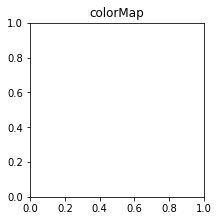

In [249]:
import numpy as np
import matplotlib.pyplot as plt

H = np.array(topics)[:,:,1][0:100]

fig = plt.figure(figsize=(6, 3.2))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(H)
ax.set_aspect('equal')



In [238]:
np.array(topics).shape

(50, 4110, 2)

In [243]:
np.array(topics)[:,:,1].shape

(50, 4110)

In [244]:
np.array(topics)[:,:,1]

array([['0.048881818', '0.048799157', '0.048554767', ..., '-0.050162893',
        '-0.050170757', '-0.050258297'],
       ['0.049504716', '0.049394455', '0.04925467', ..., '-0.04977832',
        '-0.04983893', '-0.049868286'],
       ['0.049775366', '0.049717333', '0.04971101', ..., '-0.04929211',
        '-0.04950728', '-0.04966201'],
       ...,
       ['0.05090965', '0.05077315', '0.05071448', ..., '-0.048200175',
        '-0.04823306', '-0.04834129'],
       ['0.05088855', '0.050747085', '0.050492816', ..., '-0.047529075',
        '-0.048003413', '-0.04852794'],
       ['0.04939327', '0.049211256', '0.04918533', ..., '-0.04978426',
        '-0.050031982', '-0.050061643']], dtype='<U22')

In [233]:
import umap
from sklearn.datasets import load_digits


embedding_umap_feature_weights = umap.UMAP(n_components=3, min_dist=.001, n_neighbors=50, metric='cosine').fit_transform(ae.encoder.get_weights()[0])

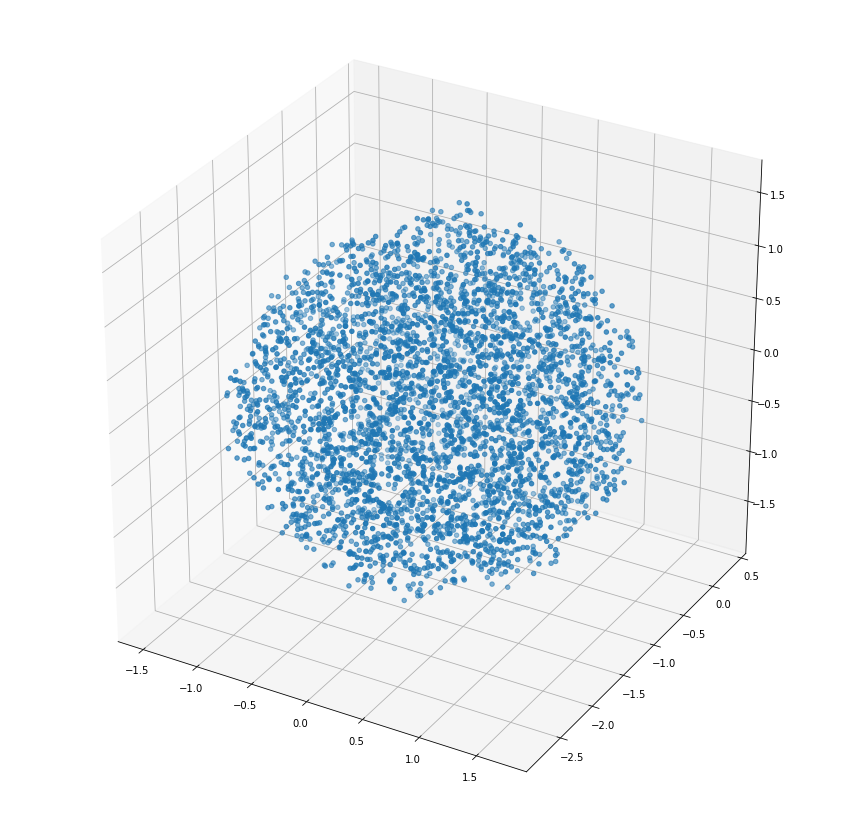

In [234]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
#X, Y, Z = axes3d.get_test_data(0.05)
X = embedding_umap_feature_weights[:,0]
Y = embedding_umap_feature_weights[:,1]
Z = embedding_umap_feature_weights[:,2]
# Plot a basic wireframe.
ax.scatter(X, Y, Z)

plt.show()

In [513]:
keras_model_weights = ae.encoder.get_weights()[0]

In [119]:
30/2

15.0

In [14]:

### Autoencoder.core.ae 
'''
Created on Nov, 2016

@author: hugo

'''
from __future__ import absolute_import
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adadelta
from keras.models import load_model as load_keras_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#from keras_utils import Dense_tied, KCompetitive, contractive_loss, CustomModelCheckpoint




input_size = len(features_names)
dim = 24
comp_topk = int(24)
ctype='kcomp'
act = 'tanh'


        # this is our input placeholder
input_layer = Input(shape=(input_size,))


encoded_layer = Dense(dim, activation=act, kernel_initializer="glorot_normal", name="Encoded_Layer")
encoded = encoded_layer(input_layer)

class KCompetitive(Layer):
    '''Applies K-Competitive layer.

    # Arguments
    '''
    def __init__(self, topk, ctype, **kwargs):
        self.topk = topk
        self.ctype = ctype
        self.uses_learning_phase = True
        self.supports_masking = True
        super(KCompetitive, self).__init__(**kwargs)

    def call(self, x):
        if self.ctype == 'ksparse':
            return K.in_train_phase(self.kSparse(x, self.topk), x)
        elif self.ctype == 'kcomp':
            return K.in_train_phase(self.k_comp_tanh_strict(x, self.topk), x)
        else:
            warnings.warn("Unknown ctype, using no competition.")
            return x

    def get_config(self):
        config = {'topk': self.topk, 'ctype': self.ctype}
        base_config = super(KCompetitive, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    # def k_comp_sigm(self, x, topk):
    #     print 'run k_comp_sigm'
    #     dim = int(x.get_shape()[1])
    #     if topk > dim:
    #         warnings.warn('topk should not be larger than dim: %s, found: %s, using %s' % (dim, topk, dim))
    #         topk = dim

    #     values, indices = tf.nn.top_k(x, topk) # indices will be [[0, 1], [2, 1]], values will be [[6., 2.], [5., 4.]]

    #     # We need to create full indices like [[0, 0], [0, 1], [1, 2], [1, 1]]
    #     my_range = tf.expand_dims(tf.range(0, K.shape(indices)[0]), 1)  # will be [[0], [1]]
    #     my_range_repeated = tf.tile(my_range, [1, topk])  # will be [[0, 0], [1, 1]]

    #     full_indices = tf.stack([my_range_repeated, indices], axis=2) # change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
    #     full_indices = tf.reshape(full_indices, [-1, 2])

    #     to_reset = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(values, [-1]), default_value=0., validate_indices=False)

    #     batch_size = tf.to_float(tf.shape(x)[0])
    #     tmp = 1 * batch_size * tf.reduce_sum(x - to_reset, 1, keep_dims=True) / topk

    #     res = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(tf.add(values, tmp), [-1]), default_value=0., validate_indices=False)

    #     return res

    def k_comp_tanh(self, x, topk=24, factor=6.26):
        print('run k_comp_tanh')
        dim = int(x.get_shape()[1])
        # batch_size = tf.to_float(tf.shape(x)[0])
        if topk > dim:
            warnings.warn('Warning: topk should not be larger than dim: %s, found: %s, using %s' % (dim, topk, dim))
            topk = dim

        P = (x + tf.abs(x)) / 2
        N = (x - tf.abs(x)) / 2
        
        
        values, indices = tf.nn.top_k(P, int(topk / 2)) # indices will be [[0, 1], [2, 1]], values will be [[6., 2.], [5., 4.]]
        # We need to create full indices like [[0, 0], [0, 1], [1, 2], [1, 1]]
        my_range = tf.expand_dims(tf.range(0, tf.shape(indices)[0]), 1)  # will be [[0], [1]]
        my_range_repeated = tf.tile(my_range, [1, int(topk / 2)])  # will be [[0, 0], [1, 1]]
        full_indices = tf.stack([my_range_repeated, indices], axis=2) # change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
        full_indices = tf.reshape(full_indices, [-1, 2])
        P_reset = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(values, [-1]), default_value=0., validate_indices=False)


        values2, indices2 = tf.nn.top_k(-N, int(topk - topk / 2) )
        my_range = tf.expand_dims(tf.range(0, tf.shape(indices2)[0]), 1)
        my_range_repeated = tf.tile(my_range, [1, int(topk - topk / 2) ])
        full_indices2 = tf.stack([my_range_repeated, indices2], axis=2)
        full_indices2 = tf.reshape(full_indices2, [-1, 2])
        N_reset = tf.sparse_to_dense(full_indices2, tf.shape(x), tf.reshape(values2, [-1]), default_value=0., validate_indices=False)


        # 1)
        # res = P_reset - N_reset
        # tmp = 1 * batch_size * tf.reduce_sum(x - res, 1, keep_dims=True) / topk

        # P_reset = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(tf.add(values, tf.abs(tmp)), [-1]), default_value=0., validate_indices=False)
        # N_reset = tf.sparse_to_dense(full_indices2, tf.shape(x), tf.reshape(tf.add(values2, tf.abs(tmp)), [-1]), default_value=0., validate_indices=False)

        # 2)
        # factor = 0.
        # factor = 2. / topk
        P_tmp = factor * tf.reduce_sum(P - P_reset, 1, keep_dims=True) # 6.26
        N_tmp = factor * tf.reduce_sum(-N - N_reset, 1, keep_dims=True)
        P_reset = tf.sparse_to_dense(full_indices, tf.shape(x), tf.reshape(tf.add(values, P_tmp), [-1]), default_value=0., validate_indices=False)
        N_reset = tf.sparse_to_dense(full_indices2, tf.shape(x), tf.reshape(tf.add(values2, N_tmp), [-1]), default_value=0., validate_indices=False)

        res = P_reset - N_reset

        return res
    
    def k_comp_tanh_strict(self, x, topk):
        print('run k_comp_tanh_strict')
        dim = int(x.get_shape()[1])
         # batch_size = tf.to_float(tf.shape(x)[0])
        if topk > dim:
            warnings.warn('Warning: topk should not be larger than dim: %s, found: %s, using %s' % (dim, topk, dim))
            topk = dim

        x_abs = tf.abs(x)
        P = (x + x_abs) / 2 # positive part of x
        N = (x - x_abs) / 2 # negative part of x

        values, indices = tf.nn.top_k(x_abs, topk) # indices will be [[0, 1], [2, 1]], values will be [[6., 2.], [5., 4.]]
         # We need to create full indices like [[0, 0], [0, 1], [1, 2], [1, 1]]
        my_range = tf.expand_dims(tf.range(0, tf.shape(indices)[0]), 1)  # will be [[0], [1]]
        my_range_repeated = tf.tile(my_range, [1, topk])  # will be [[0, 0], [1, 1]]
        full_indices = tf.stack([my_range_repeated, indices], axis=2) # change shapes to [N, k, 1] and [N, k, 1], to concatenate into [N, k, 2]
        full_indices = tf.reshape(full_indices, [-1, 2])
        x_topk_mask = tf.sparse_to_dense(full_indices, tf.shape(x), tf.ones([tf.shape(full_indices)[0], ], tf.float32), default_value=0., validate_indices=False)

        P_select = tf.multiply(P, x_topk_mask)
        N_select = tf.multiply(-N, x_topk_mask)

        zero = tf.constant(0., dtype=tf.float32)
        P_indices = tf.cast(tf.where(tf.not_equal(P_select, zero)), tf.int32)
        N_indices = tf.cast(tf.where(tf.not_equal(N_select, zero)), tf.int32)
        P_mask = tf.sparse_to_dense(P_indices, tf.shape(x), tf.ones([tf.shape(P_indices)[0], ], tf.float32), default_value=0., validate_indices=False)
        N_mask = tf.sparse_to_dense(N_indices, tf.shape(x), tf.ones([tf.shape(N_indices)[0], ], tf.float32), default_value=0., validate_indices=False)

        #alpha = 10.
        alpha = 10
        P_complement = alpha * tf.reduce_sum(P - P_select, 1, keep_dims=True)# / tf.cast(tf.shape(P_indices)[0], tf.float32) # 6.26
        N_complement = alpha * tf.reduce_sum(-N - N_select, 1, keep_dims=True)# / tf.cast(tf.shape(N_indices)[0], tf.float32)

        P_reset = tf.multiply(tf.add(P_select, P_complement), P_mask)
        N_reset = tf.multiply(tf.add(N_select, N_complement), N_mask)
        res = P_reset - N_reset

        return res
    


print('add k-competitive layer')
encoded = KCompetitive(topk = int(24), ctype = 'kcomp')(encoded)

        # "decoded" is the lossy reconstruction of the input
        # add non-negativity contraint to ensure probabilistic interpretations
decoded = Dense_tied(input_size, activation='sigmoid', tied_to=encoded_layer, name='Decoded_Layer')(encoded)

        # this model maps an input to its reconstruction
autoencoder = Model(outputs=decoded, inputs=input_layer)

        # this model maps an input to its encoded representation
encoder = Model(outputs=encoded, inputs=input_layer)

        # create a placeholder for an encoded input
encoded_input = Input(shape=(dim,))
        # retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
        # create the decoder model
decoder = Model(outputs=decoder_layer(encoded_input), inputs=encoded_input)

add k-competitive layer
run k_comp_tanh_strict


In [13]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 24396)             0         
_________________________________________________________________
Encoded_Layer (Dense)        (None, 24)                585528    
_________________________________________________________________
k_competitive_2 (KCompetitiv (None, 24)                0         
Total params: 585,528
Trainable params: 585,528
Non-trainable params: 0
_________________________________________________________________


In [213]:
2/24

0.08333333333333333

In [15]:

optimizer = Adadelta(lr=2.)
# optimizer = Adam()
# optimizer = Adagrad()

print('Using binary crossentropy')
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy') # kld, binary_crossentropy, mse

autoencoder.fit(X_train_cv, X_train_cv,
                epochs=100,
                batch_size=50,
                #shuffle=True,
                shuffle=True,
                validation_data=(X_test_cv, X_test_cv))
                #callbacks=[
                            #ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01),
                            #EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5, verbose=1, mode='auto'),
                           #CustomModelCheckpoint(self.encoder, self.save_model, monitor='val_loss', save_best_only=True, mode='auto')
              #  ]
       

Using binary crossentropy
Instructions for updating:
Use tf.cast instead.
Train on 315923 samples, validate on 155605 samples
Epoch 1/100
315923/315923 [==============================] - 148s 468us/step - loss: 0.2958 - val_loss: 0.0959
Epoch 2/100
315923/315923 [==============================] - 150s 474us/step - loss: 0.0639 - val_loss: 0.0444
Epoch 3/100
315923/315923 [==============================] - 147s 464us/step - loss: 0.0354 - val_loss: 0.0287
Epoch 4/100
315923/315923 [==============================] - 147s 465us/step - loss: 0.0245 - val_loss: 0.0211
Epoch 5/100
315923/315923 [==============================] - 147s 465us/step - loss: 0.0188 - val_loss: 0.0167
Epoch 6/100
315923/315923 [==============================] - 148s 470us/step - loss: 0.0152 - val_loss: 0.0139
Epoch 7/100
315923/315923 [==============================] - 150s 473us/step - loss: 0.0128 - val_loss: 0.0118
Epoch 8/100
315923/315923 [==============================] - 150s 476us/step - loss: 0.0110 - val

315923/315923 [==============================] - 149s 471us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 72/100
315923/315923 [==============================] - 148s 470us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 73/100
315923/315923 [==============================] - 149s 471us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 74/100
315923/315923 [==============================] - 150s 474us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 75/100
315923/315923 [==============================] - 150s 475us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 76/100
315923/315923 [==============================] - 151s 478us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 77/100
315923/315923 [==============================] - 151s 476us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 78/100
315923/315923 [==============================] - 150s 475us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 79/100
315923/315923 [==============================] - 150s 476us/step - loss: 0.0013 - val_loss: 0.0013
Epoch

In [16]:
weights = encoder.get_weights()
weights

[array([[-0.26587218, -0.28401002,  0.2740432 , ..., -0.2857697 ,
         -0.29101303, -0.27543622],
        [-0.26068148, -0.27723902,  0.28401983, ..., -0.26487258,
         -0.2922805 , -0.2786491 ],
        [-0.266863  , -0.29152963,  0.30573532, ..., -0.2937705 ,
         -0.2688846 , -0.29116237],
        ...,
        [-0.26744214, -0.2892875 ,  0.2726759 , ..., -0.2922011 ,
         -0.29459113, -0.27642262],
        [-0.27092025, -0.30094144,  0.28861994, ..., -0.28840563,
         -0.28869727, -0.27126887],
        [-0.27738568, -0.3054344 ,  0.28920892, ..., -0.2729678 ,
         -0.29256538, -0.27278826]], dtype=float32),
 array([ 4.637268 ,  4.727281 , -4.7111692, -4.7005754, -4.701844 ,
        -4.7106013,  4.6872683,  4.7262135,  4.7193594, -4.7031903,
        -4.713813 ,  4.710004 ,  4.693568 ,  4.6751227, -4.7027946,
        -4.727915 , -4.705584 ,  4.6885176,  4.693643 ,  4.7116704,
         4.646579 ,  4.6823053,  4.7143683,  4.686477 ], dtype=float32)]

In [17]:
np.abs(encoder.get_weights()[1])

array([4.637268 , 4.727281 , 4.7111692, 4.7005754, 4.701844 , 4.7106013,
       4.6872683, 4.7262135, 4.7193594, 4.7031903, 4.713813 , 4.710004 ,
       4.693568 , 4.6751227, 4.7027946, 4.727915 , 4.705584 , 4.6885176,
       4.693643 , 4.7116704, 4.646579 , 4.6823053, 4.7143683, 4.686477 ],
      dtype=float32)

In [18]:
encoded_docs = encoder.predict(X_test_cv, batch_size=int(508))

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

pca_encoded = pca.fit_transform(encoded_docs)


In [220]:
pd.DataFrame(pca_encoded[:,0]).quantile([.01, .25, .5, .75, .98], axis = 0) 

,0
0.01,0.002825
0.25,0.002878
0.50,0.002894
0.75,0.002907
0.98,0.002933


In [178]:
pd.DataFrame(pca_encoded[:,0]).quantile([.01, .25, .5, .75, .98], axis = 0)

,0
0.01,0.003666
0.25,0.003690
0.50,0.003696
0.75,0.003702
0.98,0.003713


In [177]:
pd.DataFrame(pca_encoded[:,1]).quantile([.01, .25, .5, .75, .98], axis = 0)

,0
0.01,-1.680806e-05
0.25,-3.476650e-06
0.50,5.053323e-08
0.75,3.516764e-06
0.98,1.331787e-05


In [20]:
pd.DataFrame(pca_encoded[:,2]).quantile([.01, .25, .5, .75, .98], axis = 0) 

,0
0.01,-3.076203e-06
0.25,-6.426291e-07
0.50,5.888708e-09
0.75,6.538687e-07
0.98,2.482885e-06


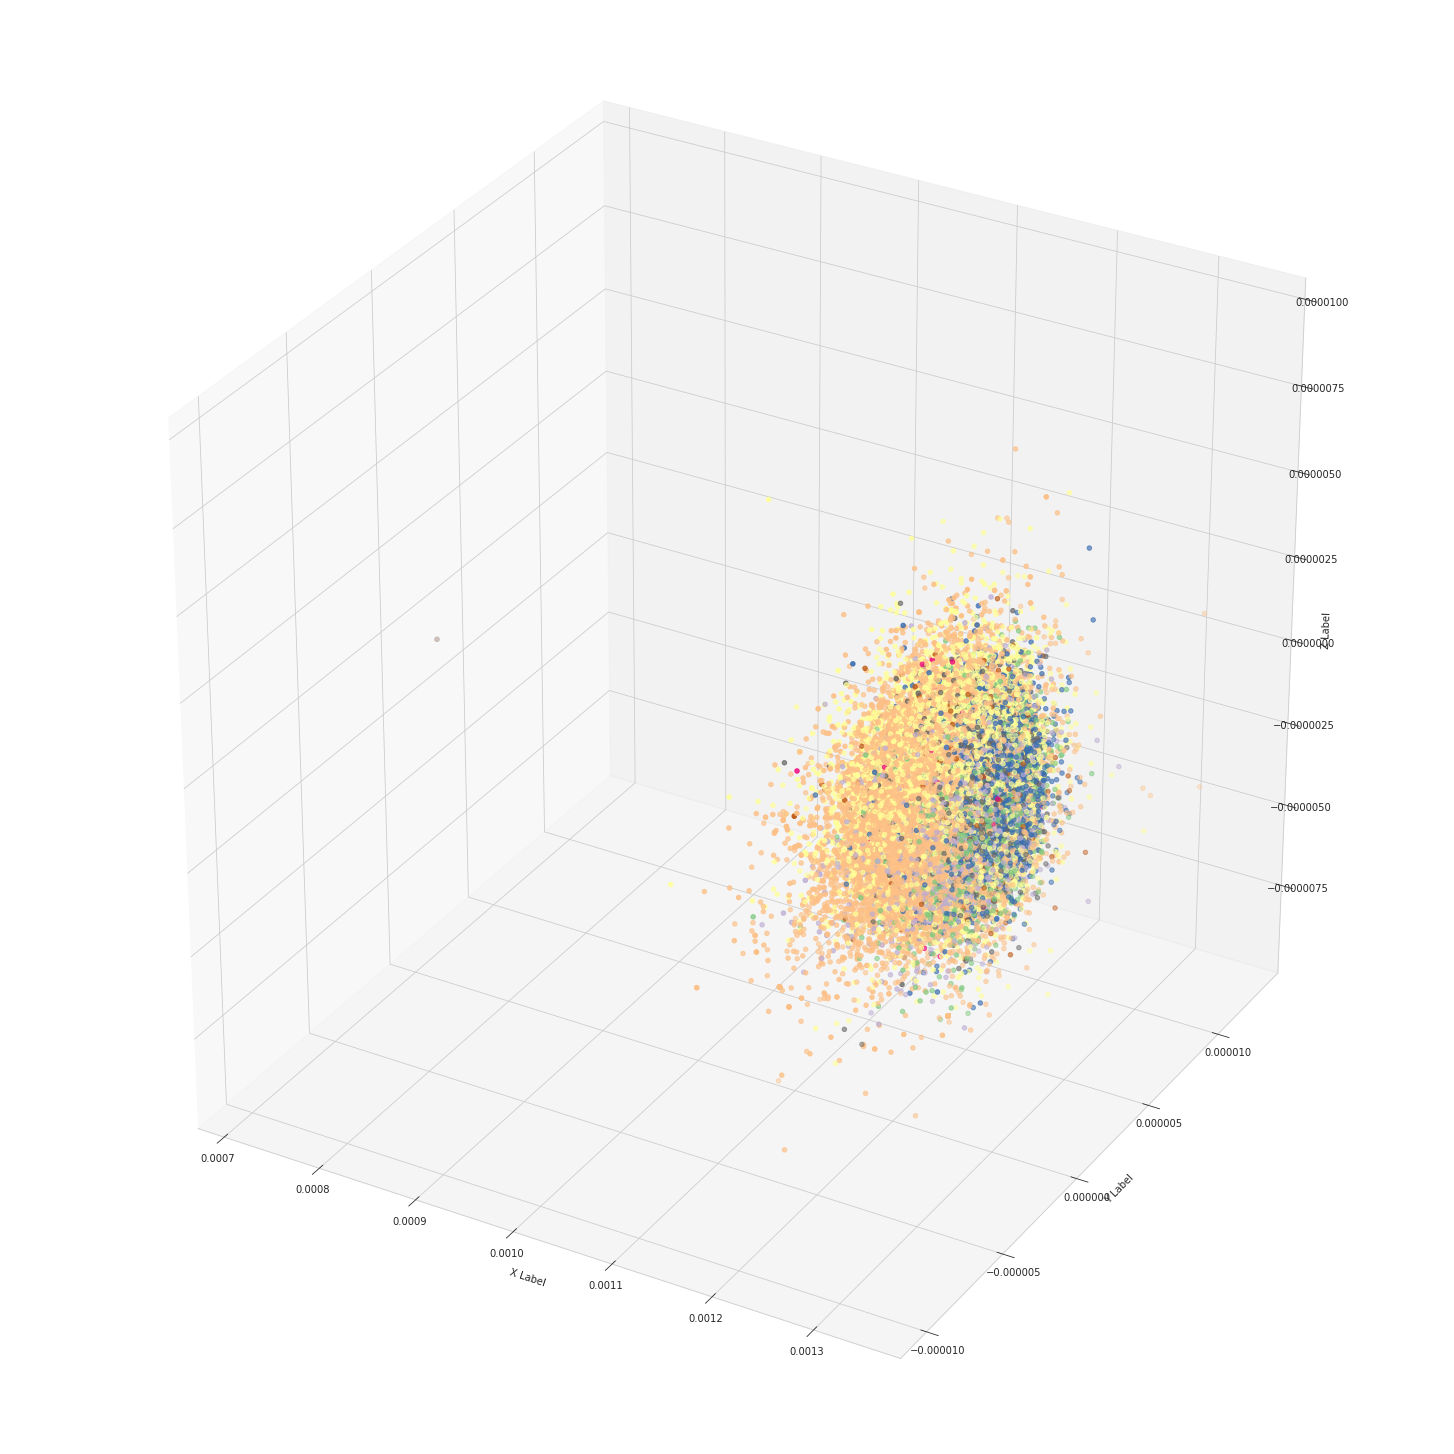

In [24]:
import re, seaborn as sns, numpy as np, pandas as pd, random
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid", {'axes.grid' : False})

fig = plt.figure(figsize=(20,20))

ax = Axes3D(fig) # Method 1
# ax = fig.add_subplot(111, projection='3d') # Method 2

x = pca_encoded[:,0]
y = pca_encoded[:,1]
z = pca_encoded[:,2]

#ax.set_xlim(0.0032, 0.0033)
ax.scatter(x, y, z, c=y_test_c, marker='o', cmap='Accent')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [ ]:

topn = 10
topics = []

weights = encoder.get_weights()[0]
for idx in range(weights.shape[1]):
    token_idx = np.argsort(weights[:, idx])[::-1][:topn]
    topics.append([(vocab_list[vocab_list[:,1] == str(x)][0][0],weights[x, idx]) for x in token_idx])

In [ ]:
weights.shape

In [ ]:

    
topic_list = []
for i in range(0, len(topics)):
    topic = topics[i]
    topic_df = pd.DataFrame(topic)
    topic_df.columns = [['word', 'weight']]
    topic_df["topic_num"] = i
    topic_df = topic_df[["word", "topic_num", 'weight']]
    
    topic_array = np.array(topic_df)
    
    topic_list_1 = []
    for array in topic_array:
        array = list(array)
        topic_list.append(array)
    
    
    #topic_list.append(topic_list_1)
    

    
topic_list = []
for i in range(0, len(topics)):
    topic = topics[i]
    topic_df = pd.DataFrame(topic)
    topic_df.columns = [['word', 'weight']]
    topic_df["topic_num"] = i
    topic_df = topic_df[["word", "topic_num", 'weight']]
    
    topic_array = np.array(topic_df)
    
    topic_list_1 = []
    for array in topic_array:
        array = list(array)
        topic_list.append(array)
    
    
    #topic_list.append(topic_list_1)
    
#topic_list = np.array(topic_list)    

pd.DataFrame(topic_list).to_csv("/home/spenser/Downloads/topic_list_strict_12.csv")

In [ ]:
np.array(topic_list).shape

In [204]:
np.array(topics).shape

(50, 25, 2)